In [1]:
import scipy
import time
import math as m
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
from scipy import optimize
from scipy import special
from scipy import stats
from scipy import linalg
from multiprocessing import Pool
import matplotlib.path as mpltPath
from numba import njit

from pylab import *
%matplotlib inline

from src import Curve as cv
from src import Utils as ut
from src import BasisFunction as bf
from src import Basis as ba
from src import Billiard as bil
from src import Solvers as solvers
from src import Wavefunctions as wf
from src import RealPlaneWaves as rpw
from src import FourierBessel as fb

rc('text', usetex=True)
rc('font', size=10)
rc('xtick', labelsize='medium')
rc('ytick', labelsize='medium')
rc('axes', labelsize='medium')
rc('legend', fontsize='small')
rc('figure', figsize=(8.6/2.54, 8.6/2.54*0.75))
rc('lines', linewidth=1.5)
rcParams["axes.formatter.limits"] = (-3,4) 


In [2]:
def plot_basis_function(basis,i,j,k):
    basis.basis_functions[i].plot_fun(j,k)

In [3]:
fb_basis = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : -1.0, "nu" : 2, "phi0" :0}])
N = 100
M = 100
fb_basis.set_basis_size([N])
x = np.random.random(M)
y = np.random.random(M)
k = 10
start_time = time.time()
A = fb_basis.evaluate_basis(k, x, y)
print("%s seconds" % (time.time() - start_time))

0.015396356582641602 seconds


In [4]:
rpw_basis = rpw.make_RPW_basis()
N = 20
M = 100
rpw_basis.set_basis_size([N,N])
x = np.random.random(M)
y = np.random.random(M)
k = 10
start_time = time.time()
A = rpw_basis.evaluate_basis(k, x, y)
print("%s seconds" % (time.time() - start_time))

0.0006513595581054688 seconds


In [5]:
#new_basis = ba.combine_basis(fb_basis, rpw_basis)

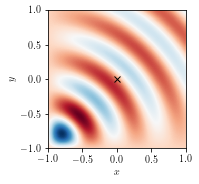

In [6]:
plot_basis_function(fb_basis,0,0,10)

In [7]:
#new_basis.plot_basis(k, figsize = (6, 6))

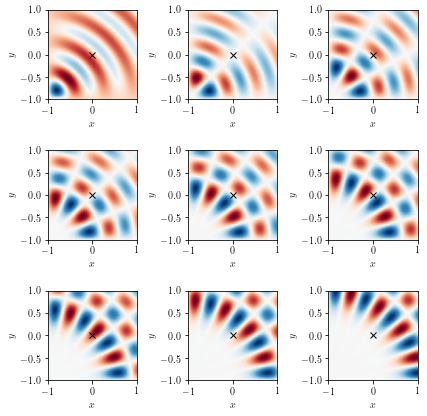

In [8]:
fb_basis.plot_basis(k)

In [25]:
%%timeit
A = rpw_basis.evaluate_basis(k, x, y)

332 µs ± 6.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
# line
def line_r(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    x = (x1-x0) * t + x0 
    y = (y1-y0) * t + y0
    return np.array([x, y])

def line_n(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    l = np.sqrt((x1 - x0)**2 + (y1 -y0)**2)
    nx = (y1 - y0)/l
    ny = (x0 - x1)/l
    return np.array([nx, ny])

def line_arc(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    l = np.sqrt((x1 - x0)**2 + (y1 -y0)**2)
    return np.array(t * l)

# circle arc
def circle_r(t, R = 1, x0 = 0, y0 = 0, angle = 2*np.pi, shift = 0):
    x = x0 + R * np.cos(t*angle + shift)
    y = y0 + R * np.sin(t*angle + shift)
    return np.array([x, y])

def circle_n(t, angle = 2*np.pi, shift = 0, **kwargs):
    nx = np.cos(t*angle + shift)
    ny = np.sin(t*angle + shift)
    return np.array([nx, ny])

def circle_arc(t, R = 1, angle = 2*np.pi, **kwargs):
    return  np.array(R * angle *t)

In [11]:
N = 10
fb_basis1 = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : -1.0, "nu" : 2, "phi0" :0}])
fb_basis2 = fb.make_FB_basis(par_list=[{"x0" : 1.0, "y0" : -0.25, "nu" : 1, "phi0" :np.pi/2}])
fb_basis3 = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : 0, "nu" : 4/3, "phi0" :-np.pi/2}])

fb_basis1.set_basis_size([N])
fb_basis2.set_basis_size([N])
fb_basis3.set_basis_size([N])

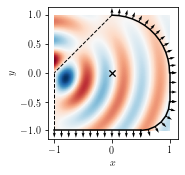

In [26]:
def make_weird_billiard(d = 15, dist = None):
    params_1 = {"angle" : np.pi/2}
    arc_1 = cv.curve(circle_r, circle_n, circle_arc, **params_1, distribution_function=dist)
    params_2 = {"x0": 0, "x1": -1, "y0": 1, "y1": 0}
    line_2 = cv.curve(line_r, line_n, line_arc, **params_2, distribution_function=dist, virtual = True)
    params_3 = {"x0": -1, "x1": -1, "y0": 0, "y1": -1}
    line_3 = cv.curve(line_r, line_n, line_arc, **params_3, distribution_function=dist, virtual = True)
    params_4 = {"x0": -1, "x1": 0.5, "y0": -1, "y1": -1}
    line_4 = cv.curve(line_r, line_n, line_arc, **params_4, distribution_function=dist)
    params_5 = {"R" : 0.5, "x0": 0.5, "y0" : -0.5 , "angle" : np.pi/2, "shift" : 3*np.pi/2}
    arc_5 = cv.curve(circle_r, circle_n, circle_arc, **params_5, distribution_function=dist)
    params_6 = {"x0": 1, "x1": 1, "y0": -0.5, "y1": 0}
    line_6 = cv.curve(line_r, line_n, line_arc, **params_6, distribution_function=dist)

    curves = [arc_1, line_2, line_3, line_4, arc_5, line_6]
    area = np.pi/4 + 1/2 + 1.5 + np.pi *0.5**2 + 0.5**2
    dens = [d for i in curves]

    return bil.billiard(curves, area, point_densities= dens)

bil1 = make_weird_billiard(d = 10, dist = None)
plot_basis_function(fb_basis3,0,0,10)
bil1.plot_boundary()



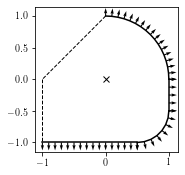

In [27]:
bil1.plot_boundary(M = 12)

In [15]:
params_1 = {"angle" : np.pi/2}
arc_1 = cv.curve(circle_r, circle_n, circle_arc, **params_1, distribution_function=None)

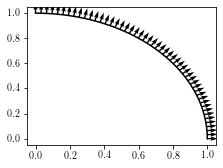

In [16]:
arc_1.plot_curve()

In [17]:
arc_1.r(np.linspace(0,1,10))

array([[1.00000000e+00, 9.84807753e-01, 9.39692621e-01, 8.66025404e-01,
        7.66044443e-01, 6.42787610e-01, 5.00000000e-01, 3.42020143e-01,
        1.73648178e-01, 6.12323400e-17],
       [0.00000000e+00, 1.73648178e-01, 3.42020143e-01, 5.00000000e-01,
        6.42787610e-01, 7.66044443e-01, 8.66025404e-01, 9.39692621e-01,
        9.84807753e-01, 1.00000000e+00]])

In [18]:
nx, ny = arc_1.normal(np.linspace(0,1,10))

In [19]:
s = arc_1.arc_length(np.linspace(0,1,10))

In [20]:
s

array([0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633])

In [21]:
x, y, nx, ny, bnd_s, ds = self.evaluate_boundary(10)

NameError: name 'self' is not defined

In [ ]:
new_basis = ba.combine_basis(fb_basis1, fb_basis3)

In [ ]:
def chebyshev_nodes(t_vals):
    N = len(t_vals)
    pts = np.arange(1,N,1)
    t = np.cos((2*pts-1)/(2*N)*np.pi)[::-1]
    return (t+1)/2
bil2 = make_weird_billiard(d = 20, dist = chebyshev_nodes)
bil2.plot_boundary()

In [ ]:
def plot_tension(billiard, basis, kmin, kmax, grid = 200):
    """Plots the tension as a function of the wavevector k in the interval [kmin, kmax].
    The tension is computed using the plane wave decomposition method.
    - N is the number of plane waves
    - grid is tne number of grid points
    """
    k_vals = np.linspace(kmin, kmax, grid)
    start_time = time.time()
    tensions = [solvers.decomposition_method(k,billiard,basis, min_basis_size = 200) for k in k_vals]
    print("%s seconds" % (time.time() - start_time))
    plt.semilogy(k_vals,tensions)
    plt.xlabel("k")
    plt.tight_layout()

In [ ]:
k0 = 2.44
dk = 0.1
plot_tension( bil2, fb_basis1, k0 -dk, k0+dk, grid = 400)
plot_tension( bil2, fb_basis2, k0 -dk, k0+dk, grid = 400)
plot_tension( bil2, fb_basis3, k0 -dk, k0+dk, grid = 400)

In [ ]:
plot_tension( bil2, new_basis, k0 -dk, k0+dk, grid = 400)

In [ ]:


fig = figure(figsize=(6,6))
plot_tension( bil1, rpw_basis, k0 -dk, k0+dk, grid = 400)
plot_tension( bil2, rpw_basis, k0 -dk, k0+dk, grid = 400)
plot_tension( bil1, fb_basis3, k0 -dk, k0+dk, grid = 400)
plot_tension( bil2, fb_basis3, k0 -dk, k0+dk, grid = 400)


In [ ]:
def PWD_eigenvalue(billiard, basis, k0, dk):
    """Uses the scipy.optimize.minimize_sclar routine to find minimum of tension in the interval [k0-dk, k0+dk]"""
    return optimize.minimize_scalar(lambda k: solvers.decomposition_method(k,billiard,basis, min_basis_size = 200), bounds=(k0-dk, k0+dk), method='bounded')

In [ ]:
PWD_eigenvalue(bil2, rpw_basis, k0, dk)

In [ ]:
PWD_eigenvalue(bil2, fb_basis3, k0, dk)

In [ ]:
wavefunctions = wf.wavefunctions(bil2, rpw_basis)

In [ ]:
wavefunctions = wf.wavefunctions(bil2, rpw_basis)
wavefunctions.plot_probability(2.448759957684761, grid = 400, cmap='binary')

In [ ]:
wavefunctions.plot_probability(2.448759957684761, grid = 400, cmap='binary',plot_full=True)

In [ ]:
wavefunctions2 = wf.wavefunctions(bil2, fb_basis3)
wavefunctions2.plot_probability(2.447712557736483, grid = 400, cmap='binary',plot_full=True)

In [ ]:
start_time = time.time()
wavefunctions.plot_boundary_function(2.448759957684761, delta = 5)
print("%s seconds" % (time.time() - start_time))

In [ ]:
start_time = time.time()
wavefunctions2.plot_boundary_function(2.407545433569129, delta = 5)
print("%s seconds" % (time.time() - start_time))

In [ ]:
start_time = time.time()
wavefunctions.plot_Husimi_function(2.448759957684761, delta = 2, cmap="binary")
print("%s seconds" % (time.time() - start_time))

In [ ]:
start_time = time.time()
wavefunctions2.plot_Husimi_function(2.448759957684761, delta = 2, cmap="binary")
print("%s seconds" % (time.time() - start_time))

In [ ]:
k1 = 3.5
k2 = 4.5
plot_tension( bil2, rpw_basis, k1, k2, grid = 400)


In [ ]:
k1 = 3.5
k2 = 4.5
plot_tension( bil1, fb_basis, k1, k2, grid = 400)
plot_tension( bil2, fb_basis, k1, k2, grid = 400)

In [ ]:
k0 = 3.9
dk = 0.1
PWD_eigenvalue(bil2, fb_basis, k0, dk)

In [ ]:
wavefunctions.plot_probability(3.9443865798628557, grid = 400, cmap='binary',plot_full=True)

In [ ]:
k0 = 3.9
dk = 0.1
PWD_eigenvalue(bil2, rpw_basis, k0, dk)

In [ ]:
wavefunctions2.plot_probability(3.9909511784148863, grid = 400, cmap='binary',plot_full=True)

In [ ]:
k0 = 200.4
dk = 0.05
VSresult = solvers.scaling_method(k0,dk, bil2,rpw_basis, min_basis_size = 200)
print(VSresult)
#tight_layout()

In [ ]:
k0 = 200.4
dk = 0.07
VSresult = solvers.scaling_method(k0,dk, bil2,fb_basis, min_basis_size = 200)
print(VSresult)
#tight_layout()

In [ ]:
RPW_basis.basis_size

In [ ]:
k0 = 2.4
dk = 0.05
N = 400
VSresult = solvers.scaling_method(k0, dk, bil1,RPW_basis, min_basis_size = N)
print(VSresult)


In [ ]:
fig = figure(figsize=(6,6))
wavefunctions.plot_probability(200.38821077, grid = 400, cmap='binary',plot_full=True)

In [ ]:
k0 = 200.38215842
dk = 0.001
sol = PWD_eigenvalue(bil1, RPW_basis, k0, dk)
print(sol)

In [ ]:
fig = figure(figsize=(6,6))
wavefunctions.plot_probability(sol.x, grid = 400, cmap='binary',plot_full=True)